<a href="https://colab.research.google.com/github/satyabratkumarsingh/option-portfolio-encoder-decoder/blob/main/evaluate_set_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [191]:
# !pip install torch
# !pip install comet_ml
# !pip install tqdm
# !pip install matplotlib

In [192]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Delete Drive files

In [193]:
import os
def delete_file_from_drive(full_file_path):
  if os.path.exists(full_file_path):
      try:
          os.remove(full_file_path)
          print(f"File '{full_file_path}' successfully deleted from Google Drive.")
      except Exception as e:
          print(f"Error deleting file '{full_file_path}': {e}")
  else:
      print(f"File '{full_file_path}' not found at '{full_file_path}'.")


# Data Generation

In [194]:
import random
import numpy as np
import torch
import itertools
from itertools import product
from torch.utils.data import Dataset, DataLoader
import gc # For garbage collection

# Parameters
MU = 0.05
SIGMA = 0.2
T = 1.0 # Time to maturity
NOISE_STD = 0.005
MIN_PRICE_RANGE = 100
MAX_PRICE_RANGE = 200

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def generate_option_prices_for_idx(idx, n, weights=None):
    # Use numpy's default_rng for better random number generation and seeding
    rng = np.random.default_rng(idx)
    # Use torch.manual_seed for PyTorch operations
    torch.manual_seed(idx)
    if DEVICE.type == 'cuda':
        torch.cuda.manual_seed_all(idx)

    # Generate S_0
    random_number = rng.integers(MIN_PRICE_RANGE, MAX_PRICE_RANGE + 1) # +1 because randint is inclusive
    min_price = random_number
    max_price = random_number + 5
    S_0 = rng.uniform(min_price, max_price)

    # Generate option types
    option_types = rng.choice(["call", "put"], size=n)
    option_types_numeric = np.where(option_types == "call", 1, 0).astype(np.float32) # Ensure float32

    # Generate X_prices (strike prices)
    K_prices = np.zeros(n, dtype=np.float32) # Ensure float32
    for i in range(n):
        K_prices[i] = S_0 * rng.uniform(0.90, 1.20)

    # Generate or use weights
    if weights is None:
        # If weights are not provided, generate them using generate_combinatorial_weights_manageable
        weight_sets = generate_combinatorial_weights_manageable(n)
        weights_array = weight_sets[0]  # Use the first (and only) set of weights
    else:
        weights_array = np.array(weights, dtype=np.float32)  # Ensure float32

    return K_prices, option_types_numeric, S_0, weights_array


def generate_combinatorial_weights_manageable(n, base_weights=[-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75]):
    weight_sets = []

    # Handle the case where n < 2
    if n < 2:
        weights = np.zeros(n, dtype=np.float32)
        if n == 1:
            # If only one position, assign a long position (1.0)
            weights[0] = 1.0
        weight_sets.append(weights)
        return weight_sets

    # Generate a single portfolio: either one long or one short, and the rest from combinatorics
    weights = np.zeros(n, dtype=np.float32)

    # Randomly choose if we want a long or short portfolio
    is_long = random.choice([True, False])

    if is_long:
        # Choose one position to be long (1.0)
        long_idx = random.randint(0, n - 1)
        weights[long_idx] = 1.0
    else:
        # Choose one position to be short (-1.0)
        short_idx = random.randint(0, n - 1)
        weights[short_idx] = -1.0

    # Fill remaining positions with combinatorial weights from base_weights
    remaining_positions = [i for i in range(n) if weights[i] == 0]  # Find positions not yet filled
    combinatorics = np.random.choice(base_weights, size=len(remaining_positions), replace=True)

    # Assign combinatorial weights to the remaining positions without normalization
    weights[remaining_positions] = combinatorics

    weight_sets.append(weights)

    return weight_sets



import torch

def black_scholes_delta(S, K, T, r, sigma, option_type):
    """
    Computes the Black-Scholes delta for a call or put option.

    Args:
        S (Tensor): Spot price [any shape]
        K (Tensor): Strike price [same shape as S or broadcastable]
        T (float or Tensor): Time to maturity (scalar or broadcastable)
        r (float or Tensor): Risk-free rate (scalar or broadcastable)
        sigma (float or Tensor): Volatility (scalar or broadcastable)
        option_type (Tensor): 1 for call, 0 for put [same shape as S]

    Returns:
        Tensor: Delta of the option [same shape as S]
    """
    eps = 1e-8  # Numerical stability for sqrt
    device = S.device

    T = torch.as_tensor(T, device=device, dtype=S.dtype)
    r = torch.as_tensor(r, device=device, dtype=S.dtype)
    sigma = torch.as_tensor(sigma, device=device, dtype=S.dtype)

    d1 = (torch.log(S / K + eps) + (r + 0.5 * sigma ** 2) * T) / (sigma * torch.sqrt(T + eps))

    # More stable, recommended: torch.special.ndtr(d1) (if available)
    N_d1 = torch.distributions.Normal(0.0, 1.0).cdf(d1)

    delta = torch.where(option_type == 1, N_d1, N_d1 - 1.0)
    return delta

def compute_cashflow(portfolio, S_T, weights):
    strikes = portfolio[..., 0]
    types = portfolio[..., 1]
    weights = weights.to(S_T.device)

    # Compute payoff-based cashflow as before
    payoffs = torch.where(
        types == 1,
        torch.relu(S_T - strikes),
        torch.relu(strikes - S_T)
    )
    weighted_payoffs = payoffs * weights
    cashflow = weighted_payoffs.sum(dim=-1, keepdim=True)

   # --- Continuous Derivative (Black-Scholes Delta) ---
    delta = black_scholes_delta(
        S_T, strikes, T=T, r=MU, sigma=SIGMA, option_type=types
    )
    weighted_delta = weights * delta
    derivative = weighted_delta.sum(dim=-1, keepdim=True)

    return cashflow.to(torch.float32), derivative.to(torch.float32)



#Dataset

In [195]:

import os
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler


class OperatorDatasetStandarization(Dataset):

    def __init__(self, num_samples, portfolio_size, num_samples_S_T,
                 K_Scalar=None, S_T_scalar=None, cashflow_scaler=None,
                 is_fitting_mode=False):

        self.num_samples = num_samples
        self.portfolio_size = portfolio_size
        self.num_samples_S_T = num_samples_S_T
        self.is_fitting_mode = is_fitting_mode # Store the mode

        # Load or generate K_Scalar and S_T_scalar
        if not self.is_fitting_mode:
          if K_Scalar is None or S_T_scalar is None or cashflow_scaler is None:
              raise ValueError("K_Scalar, S_T_scalar, and cashflow_scaler must be explicitly provided.")
          else:
            self.K_Scalar = K_Scalar
            self.S_T_scalar = S_T_scalar
            self.cashflow_scaler = cashflow_scaler
        else:
            self.K_Scalar = None
            self.S_T_scalar = None
            self.cashflow_scaler = None


    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return self.num_samples

    def __getitem__(self, idx):
        """
        Generates and returns a single data sample (portfolio, S_T, cashflow, derivative).
        This method is called by the DataLoader.
        """

        K, option_types, S_0, weights = generate_option_prices_for_idx(
            idx, self.portfolio_size
        )

        portfolio_features_tensor = torch.stack([
            torch.tensor(K, dtype=torch.float32, device=DEVICE),
            torch.tensor(option_types, dtype=torch.float32, device=DEVICE),
            torch.tensor(weights, dtype=torch.float32, device=DEVICE)
        ], dim=-1)

        weights_i = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
        K_i = torch.tensor(K, dtype=torch.float32, device=DEVICE)
        S_0_i = torch.tensor(S_0, dtype=torch.float32, device=DEVICE)
        Z = torch.clamp(torch.randn(self.num_samples_S_T, device=DEVICE), -3, 3)

        S_T_i = S_0_i * torch.exp((MU - 0.5 * SIGMA**2) * T + SIGMA * torch.sqrt(torch.tensor(T, device=DEVICE)) * Z)
        S_T_i += torch.randn_like(S_T_i, device=DEVICE) * (NOISE_STD * S_T_i)

        # Normalization for K and S_T (always apply if scalers are present and not in fitting mode)
        # Note: In fitting mode, K and S_T are still generated, but their *normalized* versions
        # are not what we're collecting for the cashflow scaler.
        if not self.is_fitting_mode:
            K_i_cpu = K_i.reshape(-1, 1).cpu()
            K_i_normalized = torch.tensor(self.K_Scalar.transform(K_i_cpu), dtype=torch.float32, device=DEVICE)
            S_T_i_normalized = torch.from_numpy(self.S_T_scalar.transform(S_T_i.cpu().numpy().reshape(-1, 1))).to(DEVICE).squeeze()
        else: # In fitting mode, just use raw K_i and S_T_i for generating raw cashflow
            K_i_normalized = K_i # This won't be used for input features directly, but kept for clarity
            S_T_i_normalized = S_T_i


        # Compute cashflow and derivative (ALWAYS raw when generated in __getitem__)
        cashflow_i_raw, derivative_i_raw = compute_cashflow(
            portfolio_features_tensor.expand(self.num_samples_S_T, -1, -1),
            S_T_i.unsqueeze(-1),
            weights_i.expand(self.num_samples_S_T, -1)
        )

        # ===== CASHFLOW NORMALIZATION (Apply only if a scaler is provided and not in fitting mode) =====
        if self.cashflow_scaler is not None and not self.is_fitting_mode:
            # Convert to numpy on CPU for scaler, then back to tensor
            cashflow_i_normalized_np = self.cashflow_scaler.transform(cashflow_i_raw.cpu().numpy().reshape(-1, 1))
            cashflow_i_to_return = torch.from_numpy(cashflow_i_normalized_np).to(DEVICE).squeeze()
        else:
            # If no scaler or in fitting mode, return the raw cashflow
            cashflow_i_to_return = cashflow_i_raw.squeeze()

        # Update portfolio_i_normalized with normalized K_i if not in fitting mode
        if not self.is_fitting_mode:
            portfolio_i_normalized = portfolio_features_tensor.clone()
            portfolio_i_normalized[:, 0] = K_i_normalized.squeeze()
        else: # In fitting mode, just return original K in portfolio_features_tensor for now
            portfolio_i_normalized = portfolio_features_tensor.clone()


        return portfolio_i_normalized, S_T_i_normalized,  cashflow_i_to_return, derivative_i_raw.squeeze()


# Model

In [196]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import math

FEED_FWD_DEPTH = 4


class TrunkNet(nn.Module):
    def __init__(self, input_dim=1, latent_dim=64, hidden_dim=128,
                 num_layers=6, dropout_prob=0.1):
        super(TrunkNet, self).__init__()

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_prob)
        )

        # Residual blocks
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.GELU(),
                nn.Dropout(dropout_prob)
            ) for _ in range(num_layers)
        ])

        # Output projection
        self.output_proj = nn.Linear(hidden_dim, latent_dim)

    def forward(self, S_T):
        if S_T.dim() == 1:
            S_T = S_T.unsqueeze(-1)
        elif S_T.dim() == 2:
            S_T = S_T.unsqueeze(-1)

        x = self.input_proj(S_T)

        # Residual connections
        for block in self.blocks:
            x = x + block(x)

        return self.output_proj(x)


class ISAB(nn.Module):
    """Induced Set Attention Block using PyTorch's MultiheadAttention"""
    def __init__(self, d_model, num_heads, num_inds, dropout=0.1):
        super().__init__()
        self.num_inds = num_inds
        self.inducing_points = nn.Parameter(torch.randn(num_inds, d_model))

        # Use PyTorch's built-in MultiheadAttention
        self.attention1 = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.attention2 = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)

        self.ffn1 = nn.Sequential(
            nn.Linear(d_model, d_model * FEED_FWD_DEPTH),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * FEED_FWD_DEPTH, d_model),
            nn.Dropout(dropout)
        )

        self.ffn2 = nn.Sequential(
            nn.Linear(d_model, d_model * FEED_FWD_DEPTH),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * FEED_FWD_DEPTH, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Expand inducing points for batch
        I = self.inducing_points.unsqueeze(0).expand(batch_size, -1, -1)

        # First attention: I attends to X
        attn_out1, _ = self.attention1(I, x, x)
        I = self.norm1(I + attn_out1)

        # Feed-forward on inducing points
        ffn_out1 = self.ffn1(I)
        I = self.norm2(I + ffn_out1)

        # Second attention: X attends to I
        attn_out2, _ = self.attention2(x, I, I)
        x = self.norm3(x + attn_out2)

        # Feed-forward on original input
        ffn_out2 = self.ffn2(x)
        x = self.norm4(x + ffn_out2)

        return x


class PMA(nn.Module):
    """Pooling by Multihead Attention using PyTorch's MultiheadAttention"""
    def __init__(self, d_model, num_heads, num_seeds, dropout=0.1):
        super().__init__()
        self.num_seeds = num_seeds
        self.seed_vectors = nn.Parameter(torch.randn(num_seeds, d_model))

        # Use PyTorch's built-in MultiheadAttention
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * FEED_FWD_DEPTH),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * FEED_FWD_DEPTH, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Expand seed vectors for batch
        S = self.seed_vectors.unsqueeze(0).expand(batch_size, -1, -1)

        # Attention: seeds attend to input
        attn_out, _ = self.attention(S, x, x)
        S = self.norm1(S + attn_out)

        # Feed-forward
        ffn_out = self.ffn(S)
        S = self.norm2(S + ffn_out)

        return S


class SAB(nn.Module):
    """Set Attention Block using PyTorch's TransformerEncoderLayer"""
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_model * FEED_FWD_DEPTH,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )

    def forward(self, x):
        return self.transformer_layer(x)


class EnhancedSetTransformerEncoder(nn.Module):
    """Set Transformer with ISAB and PMA for better generalization"""
    def __init__(self, portfolio_feature_dim=3, latent_dim=128, hidden_dim=64,
                 num_heads=2, dropout_prob=0.1, num_inds=32, num_seeds=1,
                 use_isab=True, num_layers=2):
        super().__init__()

        # Ensure hidden_dim is divisible by num_heads
        if hidden_dim % num_heads != 0:
            hidden_dim = ((hidden_dim // num_heads) + 1) * num_heads

        self.hidden_dim = hidden_dim
        self.use_isab = use_isab

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(portfolio_feature_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_prob)
        )

        # Encoder layers
        self.encoder_layers = nn.ModuleList()
        for _ in range(num_layers):
            if use_isab:
                self.encoder_layers.append(
                    ISAB(hidden_dim, num_heads, num_inds, dropout_prob)
                )
            else:
                self.encoder_layers.append(
                    SAB(hidden_dim, num_heads, dropout_prob)
                )

        # Pooling layer
        self.pooling = PMA(hidden_dim, num_heads, num_seeds, dropout_prob)

        # Output projection
        self.output_proj = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, portfolio):
        """
        Args:
            portfolio: [batch_size, portfolio_size, portfolio_feature_dim]
        Returns:
            [batch_size, latent_dim]
        """
        # Input projection
        x = self.input_proj(portfolio)  # [B, P, H]

        # Encoder layers
        for layer in self.encoder_layers:
            x = layer(x)

        # Pooling
        x = self.pooling(x)  # [B, num_seeds, H]

        # If we have multiple seeds, we can pool them further
        if x.size(1) > 1:
            x = x.mean(dim=1)  # [B, H]
        else:
            x = x.squeeze(1)  # [B, H]

        # Final projection
        out = self.output_proj(x)  # [B, latent_dim]

        return out


class OptimizedSetTransformerEncoder(nn.Module):
    """Original Set Transformer using PyTorch's built-in TransformerEncoder"""
    def __init__(self, portfolio_feature_dim=3, latent_dim=128, hidden_dim=64,
                 num_layers=1, num_heads=2, dropout_prob=0.1):
        super().__init__()

        # Ensure hidden_dim is divisible by num_heads
        if hidden_dim % num_heads != 0:
            hidden_dim = ((hidden_dim // num_heads) + 1) * num_heads

        self.hidden_dim = hidden_dim

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(portfolio_feature_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_prob)
        )

        # PyTorch's built-in TransformerEncoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * FEED_FWD_DEPTH,
            dropout=dropout_prob,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            enable_nested_tensor=False
        )

        self.output_proj = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, portfolio):
        """
        Args:
            portfolio: [batch_size, portfolio_size, portfolio_feature_dim]
        Returns:
            [batch_size, latent_dim]
        """
        x = self.input_proj(portfolio)  # [B, P, H]

        # PyTorch transformer expects [batch, seq, feature] with batch_first=True
        x = self.transformer_encoder(x)  # [B, P, H]

        pooled = x.mean(dim=1) + x.max(dim=1).values

        # Final projection
        out = self.output_proj(pooled)  # [B, latent_dim]

        return out


class OptimizedDeepONet(nn.Module):
    """DeepONet with choice of Set Transformer architectures"""
    def __init__(self, portfolio_feature_dim=3, hidden_dim=64, latent_dim=128,
                 dropout_prob=0.1, num_heads=2, use_enhanced_transformer=True,
                 num_inds=32, num_seeds=1):
        super().__init__()

        if hidden_dim % num_heads != 0:
            recommended = ((hidden_dim // num_heads) + 1) * num_heads
            raise ValueError(
                f"hidden_dim ({hidden_dim}) must be divisible by num_heads ({num_heads}). "
                f"Try hidden_dim={recommended}"
            )

        self.latent_dim = latent_dim

        # Choose branch network architecture
        if use_enhanced_transformer:
            self.branch_net = EnhancedSetTransformerEncoder(
                portfolio_feature_dim=portfolio_feature_dim,
                latent_dim=latent_dim,
                hidden_dim=hidden_dim,
                num_heads=num_heads,
                dropout_prob=dropout_prob,
                num_inds=num_inds,
                num_seeds=num_seeds,
                use_isab=True,
                num_layers=2
            )
        else:
            self.branch_net = OptimizedSetTransformerEncoder(
                portfolio_feature_dim=portfolio_feature_dim,
                latent_dim=latent_dim,
                hidden_dim=hidden_dim,
                dropout_prob=dropout_prob,
                num_heads=num_heads
            )

        # Trunk network
        self.trunk_net = TrunkNet(
            input_dim=1,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            dropout_prob=dropout_prob
        )

        # DeepONet parameters
        self.bias = nn.Parameter(torch.zeros(1))
        self.branch_scale = nn.Parameter(torch.ones(1) * 0.8)
        self.trunk_scale = nn.Parameter(torch.ones(1) * 0.8)

    def forward(self, portfolio, S_T):
        """
        Args:
            portfolio: [batch_size, portfolio_size, 3] - portfolio features
            S_T: [batch_size, num_S_T_samples] - multiple S_T values per portfolio

        Returns:
            cashflows: [batch_size, num_S_T_samples] - predicted cashflows for each S_T
        """
        # Branch network: encode portfolio
        branch_out = self.branch_net(portfolio)  # [batch_size, latent_dim]
        branch_out = branch_out * self.branch_scale

        # Trunk network: process S_T values
        trunk_out = self.trunk_net(S_T)  # [batch_size, num_S_T_samples, latent_dim]
        trunk_out = trunk_out * self.trunk_scale

        # Compute dot product: branch ⊗ trunk
        branch_expanded = branch_out.unsqueeze(1)  # [batch_size, 1, latent_dim]

        interaction = (branch_expanded * trunk_out).sum(dim=-1)  # [batch_size, num_S_T_samples]

        # Add bias
        cashflows = interaction
        return cashflows

# Evaluate and load scalars

In [197]:
# Fit ST and K

from sklearn.preprocessing import StandardScaler

DRIVE_PATH = "/content/drive/MyDrive/Ucl/"
K_SCALAR_FILE = os.path.join(DRIVE_PATH, 'K_Scalar_eval.pkl')
ST_SCALAR_FILE = os.path.join(DRIVE_PATH, 'S_T_scalar_eval.pkl')
CASHFLOW_SCALAR_FILE = os.path.join(DRIVE_PATH, 'Casflow_Scalar_eval.pkl')



def fit_K_ST_scalers(train_loader, save_path_K=K_SCALAR_FILE, save_path_ST=ST_SCALAR_FILE):
    print("Fitting K and S_T scalers from training set...")
    all_K = []
    all_S_T = []

    for batch in tqdm(train_loader, desc="Collecting K and S_T for scalers"):
        portfolio_real, s_t_real, _, _ = batch

        # K is the first column of the portfolio features
        K_real = portfolio_real[:, :, 0].cpu().numpy().reshape(-1, 1)
        S_T_real = s_t_real.cpu().numpy().reshape(-1, 1)

        all_K.append(K_real)
        all_S_T.append(S_T_real)

    K_all_np = np.concatenate(all_K, axis=0)
    S_T_all_np = np.concatenate(all_S_T, axis=0)

    K_scalar = StandardScaler()
    K_scalar.fit(K_all_np)
    joblib.dump(K_scalar, save_path_K)

    S_T_scalar = StandardScaler()
    S_T_scalar.fit(S_T_all_np)
    joblib.dump(S_T_scalar, save_path_ST)

    print(f"✅ Saved K scalar to: {save_path_K}")
    print(f"✅ Saved S_T scalar to: {save_path_ST}")
    print(f"K mean: {K_scalar.mean_[0]:.4f}, std: {K_scalar.scale_[0]:.4f}")
    print(f"S_T mean: {S_T_scalar.mean_[0]:.4f}, std: {S_T_scalar.scale_[0]:.4f}")

    return K_scalar, S_T_scalar

def fit_cashflow_scaler(train_loader, save_path=CASHFLOW_SCALAR_FILE):
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    import joblib

    all_cashflows = []

    for portfolio, s_t, cashflow, _ in tqdm(train_loader, desc="Fitting Cashflow Scaler"):
        cashflow = cashflow.detach().cpu().numpy().reshape(-1, 1)
        all_cashflows.append(cashflow)

    cashflows_np = np.concatenate(all_cashflows, axis=0)

    scaler = StandardScaler()
    scaler.fit(cashflows_np)
    joblib.dump(scaler, save_path)

    print(f"✅ Saved Cashflow Scaler to: {save_path}")
    print(f"Cashflow Mean: {scaler.mean_[0]:.4f}, Std Dev: {scaler.scale_[0]:.4f}")

    return scaler



# Evaluate

Fitting K and S_T scalers from training set...


✅ Saved K scalar to: /content/drive/MyDrive/Ucl/K_Scalar_eval.pkl
✅ Saved S_T scalar to: /content/drive/MyDrive/Ucl/S_T_scalar_eval.pkl
K mean: 160.5760, std: 33.4314
S_T mean: 160.8185, std: 45.0630


Fitting Cashflow Scaler: 100%|██████████| 79/79 [00:14<00:00,  5.58it/s]


✅ Saved Cashflow Scaler to: /content/drive/MyDrive/Ucl/Casflow_Scalar_eval.pkl
Cashflow Mean: -0.0139, Std Dev: 45.6124
Successfully loaded model from /content/drive/MyDrive/Ucl/final_deeponet_model.pt

===== DEBUGGING SAMPLE 1 =====
MSE in normalized space: 2.133616
RMSE in normalized space: 1.460690
MAE in normalized space: 1.218604

Normalized cashflow statistics:
True - Mean: 0.853001, Std: 0.447521
True - Min: 0.329344, Max: 2.341846
Pred - Mean: 2.071605, Std: 1.242836
Pred - Min: 0.970321, Max: 6.993783

Cashflow scaler properties:
Scaler mean: [-0.01386071]
Scaler scale: [45.61238167]

Denormalization verification:
Sample normalized true cashflow: [0.8951941  0.9175226  0.37015823]
Sample denormalized true cashflow: [40.818073 41.83653  16.869938]
Re-normalized (should match original): [0.8951941  0.9175226  0.37015823]
Difference from original: [0. 0. 0.]

Denormalized cashflow statistics:
True - Mean: 38.893543, Std: 20.207359
True - Min: 15.008312, Max: 106.803291
Pred - Mea

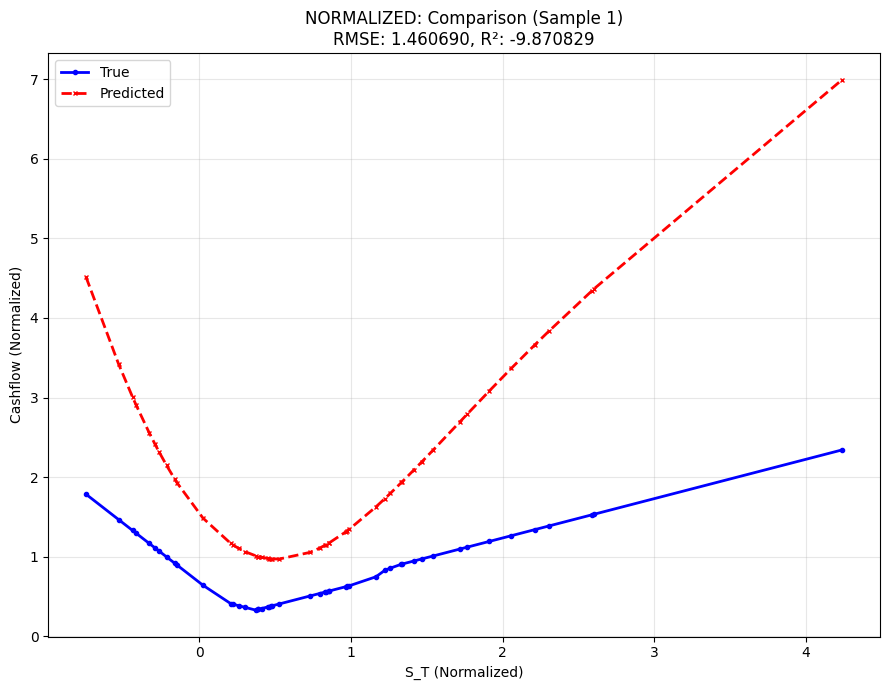

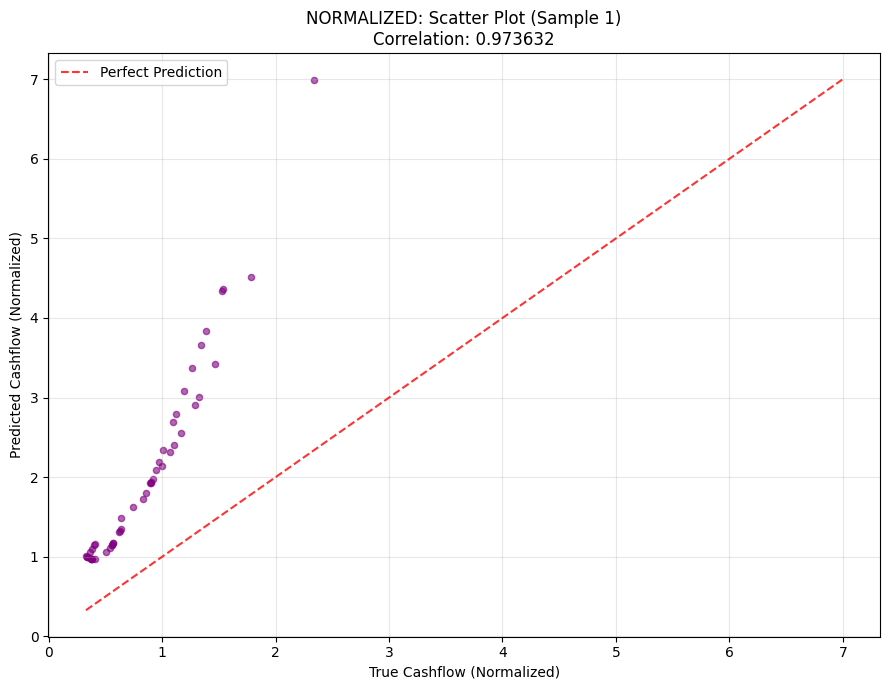

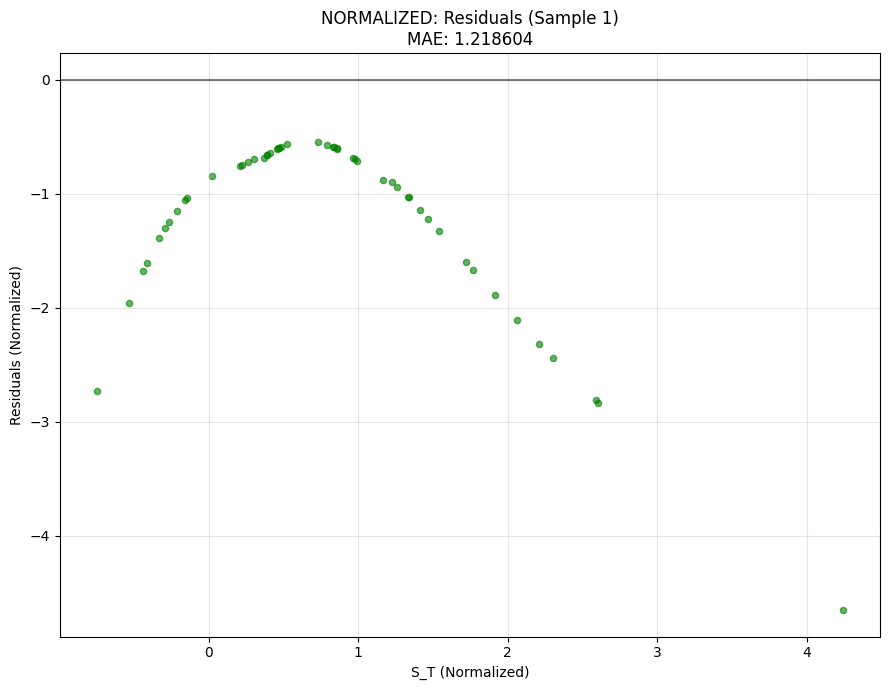

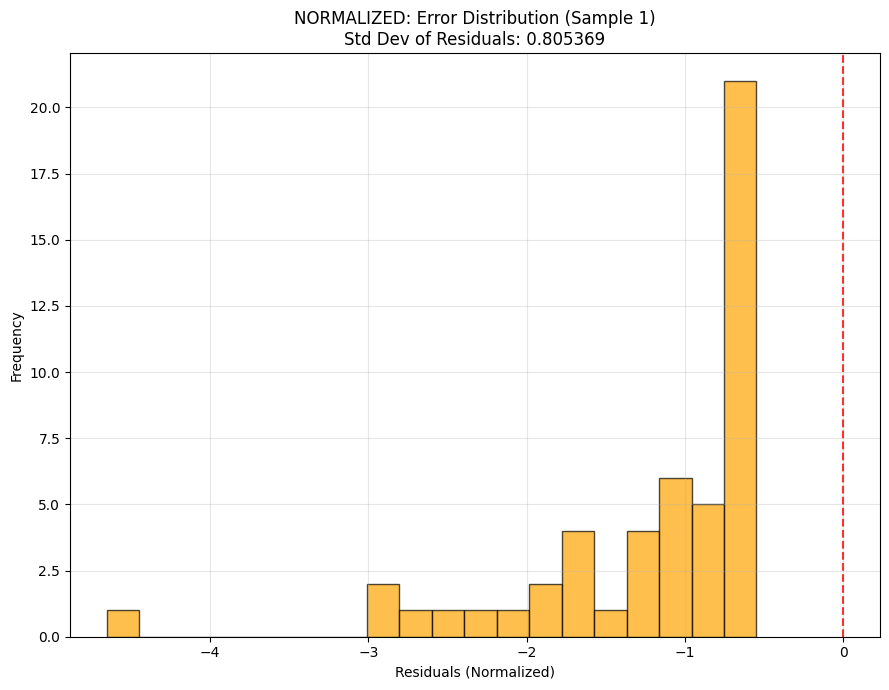

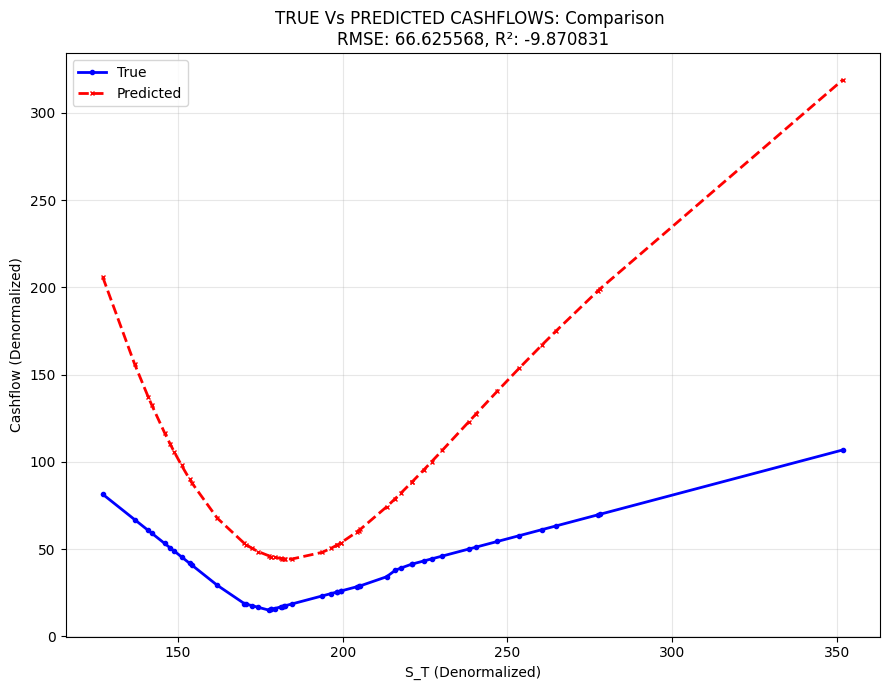

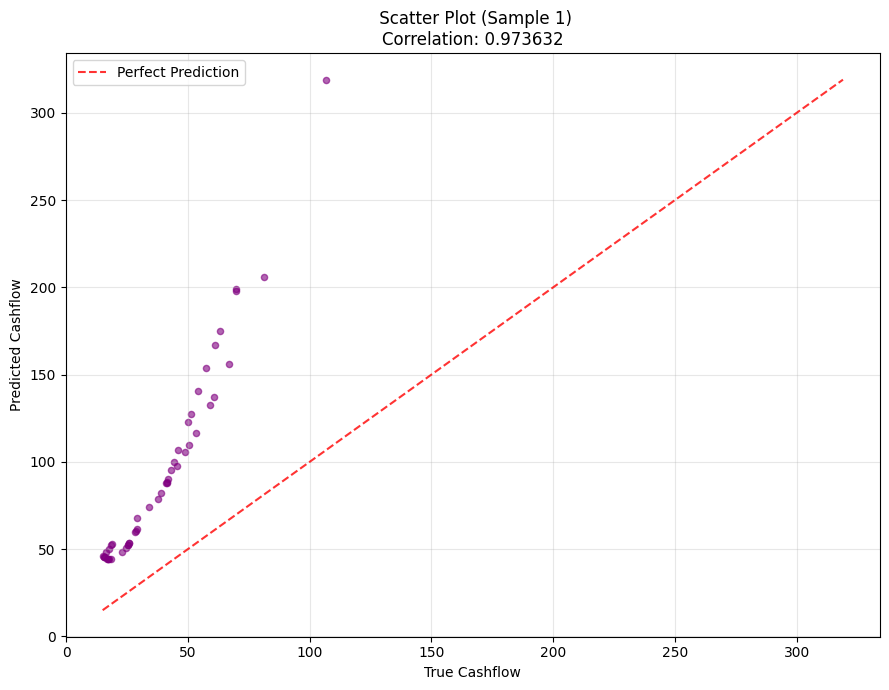

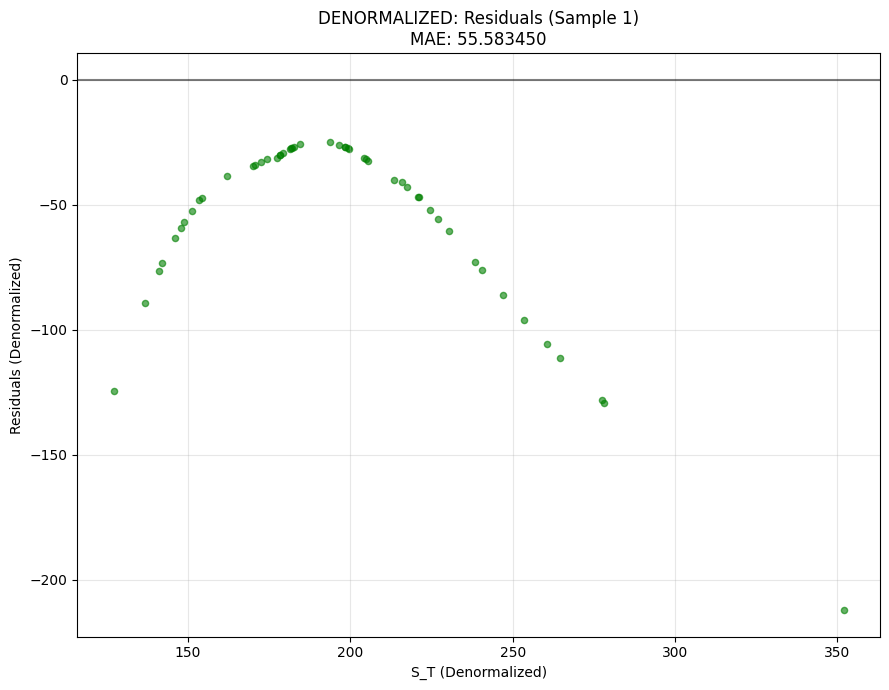

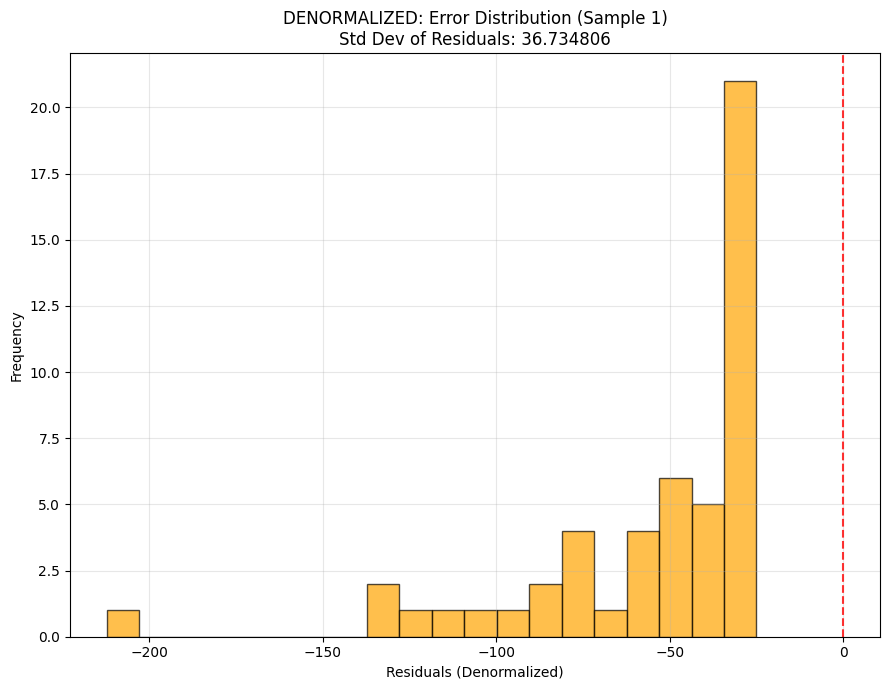


===== PROBLEMATIC REGIONS ANALYSIS =====

Large error regions in NORMALIZED space (>1.610738):
S_T_norm: -0.748369, True_norm: 1.785259, Pred_norm: 4.515682, Error_norm: -2.730423
S_T_norm: -0.533244, True_norm: 1.466458, Pred_norm: 3.421170, Error_norm: -1.954712
S_T_norm: -0.440949, True_norm: 1.329685, Pred_norm: 3.005327, Error_norm: -1.675642
S_T_norm: 1.767653, True_norm: 1.120092, Pred_norm: 2.792465, Error_norm: -1.672373
S_T_norm: 1.911287, True_norm: 1.191044, Pred_norm: 3.079547, Error_norm: -1.888503

Large error regions in DENORMALIZED space (>73.469612):
S_T: 127.094765, True: 81.416069, Pred: 205.957169, Error: -124.541100
S_T: 136.788940, True: 66.874802, Pred: 156.033859, Error: -89.159058
S_T: 140.947998, True: 60.636219, Pred: 137.066269, Error: -76.430054
S_T: 240.474274, True: 51.076191, Pred: 127.357101, Error: -76.280914
S_T: 246.946854, True: 54.312477, Pred: 140.451614, Error: -86.139137

===== COMPREHENSIVE SCALE COMPARISON =====
NORMALIZED SPACE:
  - MSE: 2.

In [198]:
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- Hyperparameters ---
hidden_dim = 64
latent_dim = 64
batch_size = 128

portfolio_feature_dim = 3 # Number of features describing each item in the portfolio

PORT_LEN = 10 # Length of the portfolio
PORT_SAMPLE_SIZE = 10000 # Total number of portfolio samples
FEED_ST_LEN_EACH_PORT = 50 # Number of S_T values for each portfolio

# Define the path where the model is expected to be saved/loaded
final_save_path = '/content/drive/MyDrive/Ucl/' # Ensure this path exists or is writable
model_path = final_save_path + 'final_deeponet_model.pt'

# --- Data Loading and Normalization ---
# Initialize raw dataset for scaler fitting (no normalization yet)
raw_dataset = OperatorDatasetStandarization(
      num_samples=PORT_SAMPLE_SIZE,
      portfolio_size=PORT_LEN,
      num_samples_S_T=FEED_ST_LEN_EACH_PORT,
      is_fitting_mode=True
      )

# Create a DataLoader for the raw dataset to fit scalers
raw_data_loader = DataLoader(raw_dataset, batch_size=batch_size, shuffle=False)

# Fit the scalers for K, S_T, and cashflows using the raw data
K_scalar, S_T_scalar = fit_K_ST_scalers(raw_data_loader)
cashflow_scaler = fit_cashflow_scaler(raw_data_loader)

# Initialize the normalized dataset using the fitted scalers
normalized_dataset = OperatorDatasetStandarization(
        num_samples=PORT_SAMPLE_SIZE,
        portfolio_size=PORT_LEN,
        num_samples_S_T=FEED_ST_LEN_EACH_PORT,
        K_Scalar=K_scalar,
        S_T_scalar=S_T_scalar,
        cashflow_scaler=cashflow_scaler,
        is_fitting_mode=False) # Now in non-fitting mode, data will be normalized

# --- Load the trained model ---
deeponet_model = OptimizedDeepONet(
    portfolio_feature_dim=portfolio_feature_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    use_enhanced_transformer= True
).to(DEVICE)

# Attempt to load the model's state dictionary
try:
    # Ensure the model file exists at the specified path
    if not os.path.exists(model_path):
        # If model file doesn't exist, create a dummy one for demonstration
        # In a real scenario, you'd train and save the model first.
        print(f"Model file not found at {model_path}. Creating a dummy model state for demonstration.")
        torch.save(deeponet_model.state_dict(), model_path)

    deeponet_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    print(f"Successfully loaded model from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}. Please ensure the model is trained and saved correctly.")
    # If loading fails, initialize a new model (for demonstration purposes)
    deeponet_model = OptimizedDeepONet(
        portfolio_feature_dim=portfolio_feature_dim,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        use_enhanced_transformer= True
    ).to(DEVICE)
    print("Proceeding with a freshly initialized model for demonstration.")

deeponet_model.eval()  # Set model to evaluation mode

# Create a DataLoader for evaluation, with batch_size=1 for individual sample analysis
eval_dataloader = DataLoader(normalized_dataset, batch_size=1, shuffle=False)

# --- Evaluation and Plotting ---
# Get a single sample for detailed analysis and plotting
with torch.no_grad(): # Disable gradient calculations for inference
    for i, (portfolio, S_T_i_normalized, true_cashflows_normalized, derivative) in enumerate(eval_dataloader):
        # Move data to the specified device (CPU or GPU)
        portfolio = portfolio.to(DEVICE)
        S_T_i_normalized = S_T_i_normalized.to(DEVICE)
        true_cashflows_normalized = true_cashflows_normalized.to(DEVICE)

        # Make prediction with the model
        predicted_cashflows_normalized = deeponet_model(portfolio, S_T_i_normalized)

        # Squeeze the batch dimension (since batch_size is 1)
        predicted_cashflows_normalized = predicted_cashflows_normalized.squeeze(0)
        true_cashflows_normalized = true_cashflows_normalized.squeeze(0)
        S_T_i_normalized = S_T_i_normalized.squeeze(0)

        print(f"\n===== DEBUGGING SAMPLE {i+1} =====")

        # 1. CHECK LOSS CALCULATION IN NORMALIZED SPACE
        mse_normalized = torch.mean((true_cashflows_normalized - predicted_cashflows_normalized) ** 2)
        print(f"MSE in normalized space: {mse_normalized.item():.6f}")
        print(f"RMSE in normalized space: {torch.sqrt(mse_normalized).item():.6f}")
        print(f"MAE in normalized space: {torch.mean(torch.abs(true_cashflows_normalized - predicted_cashflows_normalized)).item():.6f}")

        # 2. ANALYZE NORMALIZED VALUES
        print(f"\nNormalized cashflow statistics:")
        print(f"True - Mean: {true_cashflows_normalized.mean():.6f}, Std: {true_cashflows_normalized.std():.6f}")
        print(f"True - Min: {true_cashflows_normalized.min():.6f}, Max: {true_cashflows_normalized.max():.6f}")
        print(f"Pred - Mean: {predicted_cashflows_normalized.mean():.6f}, Std: {predicted_cashflows_normalized.std():.6f}")
        print(f"Pred - Min: {predicted_cashflows_normalized.min():.6f}, Max: {predicted_cashflows_normalized.max():.6f}")

        # 3. CONVERT TO NUMPY FOR SCALER OPERATIONS
        S_T_i_numpy = S_T_i_normalized.cpu().numpy()
        true_cashflows_numpy = true_cashflows_normalized.cpu().numpy()
        predicted_cashflows_numpy = predicted_cashflows_normalized.cpu().numpy()

        # 4. DENORMALIZE THE VALUES
        s_t_values_denormalized = S_T_scalar.inverse_transform(
            S_T_i_numpy.reshape(-1, 1)
        ).squeeze()

        true_cashflows_denormalized = cashflow_scaler.inverse_transform(
            true_cashflows_numpy.reshape(-1, 1)
        ).squeeze()

        predicted_cashflows_denormalized = cashflow_scaler.inverse_transform(
            predicted_cashflows_numpy.reshape(-1, 1)
        ).squeeze()

        # 5. CHECK SCALER PROPERTIES (for debugging/verification)
        print(f"\nCashflow scaler properties:")
        if hasattr(cashflow_scaler, 'mean_'): # For StandardScaler
            print(f"Scaler mean: {cashflow_scaler.mean_}")
            print(f"Scaler scale: {cashflow_scaler.scale_}")
        elif hasattr(cashflow_scaler, 'min_'): # For MinMaxScaler
            print(f"Scaler min: {cashflow_scaler.min_}")
            print(f"Scaler scale: {cashflow_scaler.scale_}")
        else:
            print(f"Scaler type: {type(cashflow_scaler)}")

        # 6. VERIFY DENORMALIZATION IS WORKING (re-normalize and compare)
        print(f"\nDenormalization verification:")
        print(f"Sample normalized true cashflow: {true_cashflows_numpy[:3]}")
        print(f"Sample denormalized true cashflow: {true_cashflows_denormalized[:3]}")

        re_normalized = cashflow_scaler.transform(true_cashflows_denormalized.reshape(-1, 1)).squeeze()
        print(f"Re-normalized (should match original): {re_normalized[:3]}")
        print(f"Difference from original: {np.abs(re_normalized[:3] - true_cashflows_numpy[:3])}")

        # 7. ANALYZE DENORMALIZED VALUES
        print(f"\nDenormalized cashflow statistics:")
        print(f"True - Mean: {true_cashflows_denormalized.mean():.6f}, Std: {true_cashflows_denormalized.std():.6f}")
        print(f"True - Min: {true_cashflows_denormalized.min():.6f}, Max: {true_cashflows_denormalized.max():.6f}")
        print(f"Pred - Mean: {predicted_cashflows_denormalized.mean():.6f}, Std: {predicted_cashflows_denormalized.std():.6f}")
        print(f"Pred - Min: {predicted_cashflows_denormalized.min():.6f}, Max: {predicted_cashflows_denormalized.max():.6f}")

        # 8. CALCULATE ERRORS IN DENORMALIZED SPACE
        mse_denormalized = mean_squared_error(true_cashflows_denormalized, predicted_cashflows_denormalized)
        mae_denormalized = mean_absolute_error(true_cashflows_denormalized, predicted_cashflows_denormalized)
        rmse_denormalized = np.sqrt(mse_denormalized)

        print(f"\nDenormalized space errors:")
        print(f"MSE: {mse_denormalized:.6f}")
        print(f"RMSE: {rmse_denormalized:.6f}")
        print(f"MAE: {mae_denormalized:.6f}")

        # 9. RELATIVE ERROR ANALYSIS (add a small epsilon to avoid division by zero)
        relative_errors = np.abs((true_cashflows_denormalized - predicted_cashflows_denormalized) / (true_cashflows_denormalized + 1e-8))
        print(f"Mean relative error: {np.mean(relative_errors):.6f}")
        print(f"Max relative error: {np.max(relative_errors):.6f}")

        # 10. CORRELATION ANALYSIS
        correlation = np.corrcoef(true_cashflows_denormalized, predicted_cashflows_denormalized)[0, 1]
        r2 = r2_score(true_cashflows_denormalized, predicted_cashflows_denormalized)
        print(f"Correlation coefficient: {correlation:.6f}")
        print(f"R² score: {r2:.6f}")

        # 11. NORMALIZED SPACE METRICS (re-calculate for clarity)
        correlation_normalized = np.corrcoef(true_cashflows_numpy, predicted_cashflows_numpy)[0, 1]
        r2_normalized = r2_score(true_cashflows_numpy, predicted_cashflows_numpy)
        mae_normalized = mean_absolute_error(true_cashflows_numpy, predicted_cashflows_numpy)
        rmse_normalized = np.sqrt(mse_normalized.item()) # Already calculated, just for consistency

        print(f"\nNormalized space metrics:")
        print(f"Correlation coefficient: {correlation_normalized:.6f}")
        print(f"R² score: {r2_normalized:.6f}")

        # 12. SORT DATA FOR PLOTTING (important for line plots)
        # For normalized plots: sort by S_T_i_numpy
        sorted_indices_norm = np.argsort(S_T_i_numpy)
        s_t_values_norm_sorted = S_T_i_numpy[sorted_indices_norm]
        true_cashflows_norm_sorted = true_cashflows_numpy[sorted_indices_norm]
        predicted_cashflows_norm_sorted = predicted_cashflows_numpy[sorted_indices_norm]

        # For denormalized plots: sort by s_t_values_denormalized
        sorted_indices = np.argsort(s_t_values_denormalized)
        s_t_values_sorted = s_t_values_denormalized[sorted_indices]
        true_cashflows_sorted = true_cashflows_denormalized[sorted_indices]
        predicted_cashflows_sorted = predicted_cashflows_denormalized[sorted_indices]

        # --- 13. COMPREHENSIVE PLOTTING - ONE AFTER ANOTHER ---

        # Plot 1: Normalized Comparison
        plt.figure(figsize=(9, 7)) # Create a new figure for each plot
        plt.plot(s_t_values_norm_sorted, true_cashflows_norm_sorted,
                       label='True', color='blue', marker='o', markersize=3, linewidth=2)
        plt.plot(s_t_values_norm_sorted, predicted_cashflows_norm_sorted,
                       label='Predicted', color='red', linestyle='--', marker='x', markersize=3, linewidth=2)
        plt.xlabel('S_T (Normalized)')
        plt.ylabel('Cashflow (Normalized)')
        plt.title(f'NORMALIZED: Comparison (Sample {i+1})\nRMSE: {rmse_normalized:.6f}, R²: {r2_normalized:.6f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show() # Display this plot

        # Plot 2: Normalized Scatter Plot
        plt.figure(figsize=(9, 7))
        plt.scatter(true_cashflows_numpy, predicted_cashflows_numpy,
                          alpha=0.6, color='purple', s=20)
        min_val_norm = min(true_cashflows_numpy.min(), predicted_cashflows_numpy.min())
        max_val_norm = max(true_cashflows_numpy.max(), predicted_cashflows_numpy.max())
        plt.plot([min_val_norm, max_val_norm], [min_val_norm, max_val_norm], 'r--', alpha=0.8, label='Perfect Prediction')
        plt.xlabel('True Cashflow (Normalized)')
        plt.ylabel('Predicted Cashflow (Normalized)')
        plt.title(f'NORMALIZED: Scatter Plot (Sample {i+1})\nCorrelation: {correlation_normalized:.6f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show() # Display this plot

        # Plot 3: Normalized Residuals Plot
        plt.figure(figsize=(9, 7))
        residuals_norm = true_cashflows_norm_sorted - predicted_cashflows_norm_sorted
        plt.scatter(s_t_values_norm_sorted, residuals_norm, alpha=0.6, color='green', s=20)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.xlabel('S_T (Normalized)')
        plt.ylabel('Residuals (Normalized)')
        plt.title(f'NORMALIZED: Residuals (Sample {i+1})\nMAE: {mae_normalized:.6f}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show() # Display this plot

        # Plot 4: Normalized Error Distribution (Histogram of Residuals)
        plt.figure(figsize=(9, 7))
        plt.hist(residuals_norm, bins=20, alpha=0.7, color='orange', edgecolor='black')
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.8)
        plt.xlabel('Residuals (Normalized)')
        plt.ylabel('Frequency')
        plt.title(f'NORMALIZED: Error Distribution (Sample {i+1})\nStd Dev of Residuals: {np.std(residuals_norm):.6f}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show() # Display this plot

        # Plot 5: Denormalized Comparison
        plt.figure(figsize=(9, 7))
        plt.plot(s_t_values_sorted, true_cashflows_sorted,
                       label='True', color='blue', marker='o', markersize=3, linewidth=2)
        plt.plot(s_t_values_sorted, predicted_cashflows_sorted,
                       label='Predicted', color='red', linestyle='--', marker='x', markersize=3, linewidth=2)
        plt.xlabel('S_T (Denormalized)')
        plt.ylabel('Cashflow (Denormalized)')
        plt.title(f'TRUE Vs PREDICTED CASHFLOWS: Comparison \nRMSE: {rmse_denormalized:.6f}, R²: {r2:.6f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show() # Display this plot

        # Plot 6: Denormalized Scatter Plot
        plt.figure(figsize=(9, 7))
        plt.scatter(true_cashflows_denormalized, predicted_cashflows_denormalized,
                          alpha=0.6, color='purple', s=20)
        min_val = min(true_cashflows_denormalized.min(), predicted_cashflows_denormalized.min())
        max_val = max(true_cashflows_denormalized.max(), predicted_cashflows_denormalized.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
        plt.xlabel('True Cashflow')
        plt.ylabel('Predicted Cashflow')
        plt.title(f' Scatter Plot (Sample {i+1})\nCorrelation: {correlation:.6f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show() # Display this plot

        # Plot 7: Denormalized Residuals Plot
        plt.figure(figsize=(9, 7))
        residuals = true_cashflows_sorted - predicted_cashflows_sorted
        plt.scatter(s_t_values_sorted, residuals, alpha=0.6, color='green', s=20)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.xlabel('S_T (Denormalized)')
        plt.ylabel('Residuals (Denormalized)')
        plt.title(f'DENORMALIZED: Residuals (Sample {i+1})\nMAE: {mae_denormalized:.6f}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show() # Display this plot

        # Plot 8: Denormalized Error Distribution (Histogram of Residuals)
        plt.figure(figsize=(9, 7))
        plt.hist(residuals, bins=20, alpha=0.7, color='orange', edgecolor='black')
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.8)
        plt.xlabel('Residuals (Denormalized)')
        plt.ylabel('Frequency')
        plt.title(f'DENORMALIZED: Error Distribution (Sample {i+1})\nStd Dev of Residuals: {np.std(residuals):.6f}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show() # Display this plot

        # 14. IDENTIFY PROBLEMATIC REGIONS IN BOTH SPACES
        print(f"\n===== PROBLEMATIC REGIONS ANALYSIS =====")

        # Normalized space
        large_errors_norm = np.abs(residuals_norm) > 2 * np.std(residuals_norm)
        if np.any(large_errors_norm):
            print(f"\nLarge error regions in NORMALIZED space (>{2 * np.std(residuals_norm):.6f}):")
            large_error_indices_norm = np.where(large_errors_norm)[0]
            for idx in large_error_indices_norm[:5]:  # Show first 5 problematic points
                print(f"S_T_norm: {s_t_values_norm_sorted[idx]:.6f}, True_norm: {true_cashflows_norm_sorted[idx]:.6f}, "
                      f"Pred_norm: {predicted_cashflows_norm_sorted[idx]:.6f}, Error_norm: {residuals_norm[idx]:.6f}")
        else:
            print("No significantly large errors found in normalized space (within 2 standard deviations).")

        # Denormalized space
        large_errors = np.abs(residuals) > 2 * np.std(residuals)
        if np.any(large_errors):
            print(f"\nLarge error regions in DENORMALIZED space (>{2 * np.std(residuals):.6f}):")
            large_error_indices = np.where(large_errors)[0]
            for idx in large_error_indices[:5]:  # Show first 5 problematic points
                print(f"S_T: {s_t_values_sorted[idx]:.6f}, True: {true_cashflows_sorted[idx]:.6f}, "
                      f"Pred: {predicted_cashflows_sorted[idx]:.6f}, Error: {residuals[idx]:.6f}")
        else:
            print("No significantly large errors found in denormalized space (within 2 standard deviations).")

        # 15. COMPREHENSIVE SCALE COMPARISON
        print(f"\n===== COMPREHENSIVE SCALE COMPARISON =====")
        print(f"NORMALIZED SPACE:")
        print(f"  - MSE: {mse_normalized.item():.6f}")
        print(f"  - RMSE: {rmse_normalized:.6f}")
        print(f"  - MAE: {mae_normalized:.6f}")
        print(f"  - R²: {r2_normalized:.6f}")
        print(f"  - Correlation: {correlation_normalized:.6f}")

        print(f"\nDENORMALIZED SPACE:")
        print(f"  - MSE: {mse_denormalized:.6f}")
        print(f"  - RMSE: {rmse_denormalized:.6f}")
        print(f"  - MAE: {mae_denormalized:.6f}")
        print(f"  - R²: {r2:.6f}")
        print(f"  - Correlation: {correlation:.6f}")

        print(f"\nSCALE INSIGHTS:")
        # Add a small epsilon to the denominator to prevent division by zero for range calculation
        denormalized_range = true_cashflows_denormalized.max() - true_cashflows_denormalized.min()
        if denormalized_range > 1e-8: # Check if range is significant
            print(f"  - Denormalized range: {denormalized_range:.6f}")
            print(f"  - RMSE as % of range: {(rmse_denormalized / denormalized_range) * 100:.2f}%")
        else:
            print("  - Denormalized range is too small to calculate meaningful RMSE as % of range.")

        print(f"  - Mean relative error: {np.mean(relative_errors):.6f}")
        print(f"  - Max relative error: {np.max(relative_errors):.6f}")

        # Break after the first sample's analysis and plotting, as requested
        if i == 0:
            break


In [199]:
def add(a, b):
  return a + b

print(add(10,5))

15
